# Creating a General Purpose Potential for Molecular Crystals - Part 2

This notebook is used to create a general purpose GAP potential for molecular crystals. The potential is built on PBE-D3 data from short PIMD simulations of 2238 different molecular crystals. Please note that it has a high (~150 GB) memory requirement to run fully.

In this part of the notebook: 
- SOAP hyperparameters are optimised for a KRR model
- The KRR model is tested with optimal hyperparameters

### Import modules, functions, and necessary raw data from part 1

In [13]:
#Import modules
from matplotlib import pylab as plt
from tqdm import tqdm
import itertools

import pickle
import numpy as np
from sklearn import linear_model
import skcosmo.feature_selection
from skcosmo.feature_selection import FPS
from skcosmo.sample_selection import PCovCUR
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.kernel_ridge import KernelRidge

import ase
from ase.io import read, write
from ase.build import make_supercell
from ase.visualize import view
import numpy as np
# If installed -- not essential, though
try:
    from tqdm.notebook import tqdm
except ImportError:
    tqdm = (lambda i, **kwargs: i)

from time import time

from rascal.models import KRR
from rascal.utils import dump_obj, load_obj

from rascal.models import Kernel, train_gap_model, compute_KNM
from rascal.representations import SphericalInvariants
from rascal.utils import from_dict, to_dict, CURFilter, FPSFilter, dump_obj, load_obj
from rascal.utils import get_score
from rascal.utils.io import load_json, dump_json


In [89]:
#Define functions
def do_fps(x, d=0):
    """
    Function for performing farthest-point-sampling for a given feature matrix.
    d gives the number of farthest-point-sampled feature vectors that will be outputted. 
    If d==0, the entire set will be FPS-sorted.
    Returns the FPS-sorted IDs, as well as the FPS distances.
    """
    if d == 0 : d = len(x)
    n = len(x)
    iy = np.zeros(d, int)
    # faster evaluation of Euclidean distance
    n2 = np.sum(x**2,axis=1)
    iy[0] = 0
    dl = n2 + n2[iy[0]] - 2* np.dot(x, x[iy[0]])
    dss = []
    for i in range(1,d):
        iy[i] = np.argmax(dl)
        nd = n2 + n2[iy[i]] - 2*np.dot(x,x[iy[i]])
        dl = np.minimum(dl, nd)
        dss.append(max(dl))
    return iy,dss

def get_forces(frames):
    frc = np.zeros((np.sum([len(frm) for frm in frames]),3))
    iat = 0
    for ifrm,frm in enumerate(frames):
        frc[iat:iat+len(frm)] = frm.get_array('forces') 
        iat += len(frm)
    return frc

#Get feature vectors for a list of atoms objects. This requires soap to be set, as well as all_species, which is
#a list with one atoms object that contains all species HCNO
def get_features(atoms_objects, batch_size=1000):
    struct_feat=[] #create empty feature vector of n_structures x n_features
    got_frame = False
    for frm in atoms_objects:
        while got_frame == False: 
            if all(sp in frm.get_atomic_numbers() for sp in [1,6,7,8]) == True:
                all_species = frm
                got_frame = True
    for i in range(int(len(atoms_objects)/batch_size+0.9999)): #Get feature vectors in batches of 1000
        for frm in atoms_objects[i*batch_size:(i+1)*batch_size]:
            frm.wrap(eps=1e-13) #wrap atoms in unit cell
        frames=[all_species.copy()] #add initial frame with all species
        frames.extend(atoms_objects[i*batch_size:(i+1)*batch_size]) #extend initial frame with frames of batch
        manager = soap.transform(frames) #calculate soap features for all structures in batch
        env_feat_batch = manager.get_features(soap)[len(all_species):] #get feature vectors for all structures in batch
        # (having removed the initial frame)
        atom_counter=0 #count atoms
        for ifrm,frm in enumerate(atoms_objects[i*batch_size:(i+1)*batch_size]): #iterate over frames in batch
            nat=len(frm) #count atoms in frame
            struct_feat.append(np.mean(env_feat_batch[atom_counter:atom_counter+nat],axis=0)) #average vectors
            # for atoms in the same frame. Done by averaging vectors between atom_counter and atom_counter + nat
            atom_counter+=nat #add atoms to counter
    struct_feat_array=np.asarray(struct_feat)
    return struct_feat_array

In [87]:
#Import data
db_fps=np.load('raw_data/CSD-10k_per_crystal_fps_w_kpts.npy', allow_pickle=True)
struct_feat = np.load('raw_data/CSD-10k_features_train_set.npy')
train_set = np.load('raw_data/CSD-10k_train_set.npy', allow_pickle=True)
val_set = np.load('raw_data/CSD-10k_val_set.npy', allow_pickle=True)
test_set = np.load('raw_data/CSD-10k_test_set.npy', allow_pickle=True)
fps_ids = np.load('raw_data/CSD-10k_train_set_FPS_ids.npy')
fps_dist = np.load('raw_data/CSD-10k_train_set_FPS_dist.npy')
X_train = np.load('raw_data/X_train.npy') 
y_train = np.load('raw_data/y_train.npy')
X_val = np.load('raw_data/X_val.npy') 
y_val = np.load('raw_data/y_val.npy')
X_test = np.load('raw_data/X_test.npy') 
y_test = np.load('raw_data/y_test.npy')
with open('raw_data/mlr.pkl', 'rb') as mlr_file:
    mlr = pickle.load(mlr_file)

In [52]:
#Define soap hyperparameters from part 1 (will be chnaged soon)
hypers = dict(soap_type="PowerSpectrum",
              interaction_cutoff=6, #cutoff distance in angstroms
              max_radial=6, #no. of radial basis functions
              max_angular=6, #no. of angular basis functions
              gaussian_sigma_constant=0.4, #sigma width (i.e. amount of 'smearing')
              gaussian_sigma_type="Constant",
              cutoff_function_type="RadialScaling",
              cutoff_smooth_width=0.5,
              cutoff_function_parameters=
                    dict(
                            rate=1,
                            scale=2,
                            exponent=2
                        ),
              radial_basis="GTO",
              normalize=True,
              optimization=
                    dict(
                            Spline=dict(
                               accuracy=1.0e-05
                            )
                        ),
              compute_gradients=False #don't care about forces right now
              )
soap = SphericalInvariants(**hypers)


## Quasi-learning curve (quick test)
A quasi-leanring loop is set up in order to see how well the KRR model can learn energies using increasing training set sizes. Please note that SOAP hyperparameters have not been optimised yet, and so the errors at each iteration can most likely be reduced further. The regularization parameter is already optimised in this loop. This is just an academic exercise, as hyperparameters will optimised below this, and then a quasi-active learning loop will be set up in order to iteratively add training strucutres to the model in batches.

In [88]:
#Quasi-learning curve
lc = []
val_feat = get_features(val_set, batch_size=500) #Get feature vectors for validation database
for npc in tqdm(range(1,9)):
    #Train on npc* 2238 structures (npc per crystal)
    initial_train_set = [train_set[idx] for idx in fps_ids[:npc*2238]]
    initial_train_feat = np.asarray([struct_feat[idx] for idx in fps_ids[:npc*2238]])

    #Create a matrix of n_structures x n_atoms_per_species (i.e. 2238 x 4 matrix), and a vectors with energies of structures
    X_train = np.zeros((len(initial_train_set),4),dtype=int) #create matrix
    y_train=np.zeros(len(initial_train_set)) #create vector
    for ifrm, frm in enumerate(initial_train_set):
        symbols=frm.get_atomic_numbers() #get atomic numbers from frame
        y_train[ifrm]=(frm.info['energy']) #get energy from frame
        X_train[ifrm]=[len(np.where(symbols == sp)[0]) for sp in [1,6,7,8]] #create vector of [n_H, n_C, n_N, n_O] and add to matrix

    zeta = 2
    K = np.dot(initial_train_feat,initial_train_feat.T)**zeta #compute kernel for training
    Kval = np.dot(val_feat,initial_train_feat.T)**zeta #compute kernel for validation
    y = y_train/np.sum(X_train,axis=1)-mlr.predict(X_train)/np.sum(X_train,axis=1)# per-atom binding energies

    #Compute predictions with various regularization constants, and save the minimum constant (with associated error)
    yred_val = y_val/np.sum(X_val,axis=1)-mlr.predict(X_val)/np.sum(X_val,axis=1) #baselined per-atom binding energies
                                                                                  #of validation set
    minerr = 1e24 ; minreg = 0
    for reg in np.logspace(-9,-3,7):
        KRR = KernelRidge(kernel='precomputed',alpha = reg)
        KRR.fit(K,y)
        err = np.std(yred_val - KRR.predict(Kval)) #compute error between true and predicted energies for validation set
        if err < minerr: #if computed error is less than the previously stored minimum energy
            minreg = reg #save regularization value
            minerr = err #save computed error
    print(npc,minreg,np.round(minerr,4))
    lc.append(minerr)

60
501
46776
60
501
44199


  0%|          | 0/8 [00:00<?, ?it/s]

1 1e-06 0.0142
2 1e-06 0.0097
3 1e-07 0.0076
4 1e-06 0.0064


KeyboardInterrupt: 

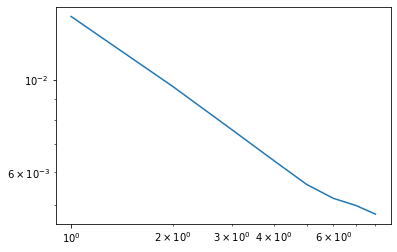

In [28]:
# Plot leanring rate
f,p = plt.subplots(1,1)
p.loglog(range(1,9),lc)

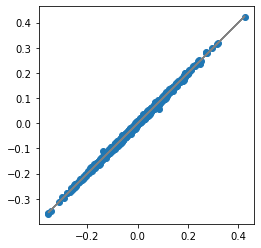

In [29]:
# Plot results of best-performing KRR model
KRR = KernelRidge(kernel='precomputed',alpha = minreg)
KRR.fit(K,y)

f,p = plt.subplots(1,1)
p.plot(y_val/np.sum(X_val,axis=1)-mlr.predict(X_val)/np.sum(X_val,axis=1), y_val/np.sum(X_val,axis=1)-mlr.predict(X_val)/np.sum(X_val,axis=1), '-', c='grey')
p.scatter(y_val/np.sum(X_val,axis=1)-mlr.predict(X_val)/np.sum(X_val,axis=1), KRR.predict(Kval))
p.set_aspect(1)



#### Optimization of zeta and regularization constants

1 1e-08 0.012
2 1e-07 0.005
3 1e-06 0.005
4 1e-07 0.005


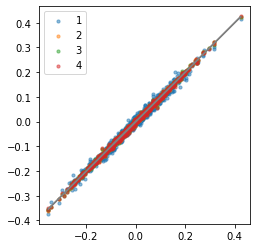

In [127]:
f,p = plt.subplots(1,1)
p.plot(yred_val, yred_val, '-', c='grey')
    
#Compute predictions with various zeta values, and save the minimum zeta (with associated error)
for zeta in [1,2,3,4]:
    K = np.dot(initial_train_feat,initial_train_feat.T)**zeta
    Kval = np.dot(val_feat,initial_train_feat.T)**zeta
    y = y_train/np.sum(X_train,axis=1)-mlr.predict(X_train)/np.sum(X_train,axis=1)# per-atom binding energies

    minerr = 1e24 ; minreg = 0
    for reg in np.logspace(-9,-3,7):
        KRR = KernelRidge(kernel='precomputed',alpha = reg)
        KRR.fit(K,y)
        err = np.std(yred_val - KRR.predict(Kval))
        if err < minerr:
            minreg = reg
            minerr = err
    print(zeta,minreg,np.round(minerr,5))

    KRR = KernelRidge(kernel='precomputed',alpha = minreg)
    KRR.fit(K,y)

    p.scatter(yred_val, KRR.predict(Kval),alpha=0.5,s=10,label=str(zeta))
p.set_aspect(1)
p.legend()

## Loop for hyperparameter optimisation
Loop for optimisaing SOAP hyperparameters, as well as zeta and regularization constants. This loop can take several hours, and so the results have been saved and can be reloaded below. 

### Create initial training set
As seen from the quasi-active learning curve, an acceptable error is obtained when training a model on 4 configurations per crystal. Therefore, hyperparameters are optimised using this number of training configurations. It is assumed that the optimal hyperparameters for this set will be the same or similar when adding or removing some configurations, but this is definitely not a certainty.

In [93]:
#Train on npc* 2238 FPS-sorted structures (npc = numer of configurations per crystal)
npc = 4
initial_train_set = [train_set[idx] for idx in fps_ids[:npc*2238]]

yred_train = y_train/np.sum(X_train,axis=1)-mlr.predict(X_train)/np.sum(X_train,axis=1)#Baselined per-atom binding energies of training set
yred_val = y_val/np.sum(X_val,axis=1)-mlr.predict(X_val)/np.sum(X_val,axis=1) #Baselined per-atom binding energies of validation set

np.save('raw_data/initial_train_set_4pc', np.asarray(initial_train_set, dtype='object')) #Save initial training set

In [90]:
#Create composition matrix and energies vector for the initial training set
X_train_fps = np.zeros((len(initial_train_set),4),dtype=int)
y_train_fps = np.zeros(len(initial_train_set))
for ifrm, frm in enumerate(initial_train_set):
    symbols=frm.get_atomic_numbers()
    y_train_fps[ifrm]=(frm.info['energy'])
    X_train_fps[ifrm]=[len(np.where(symbols == sp)[0]) for sp in [1,6,7,8]]
    
np.save('raw_data/X_train_fps', X_train_fps)
np.save('raw_data/y_train_fps', y_train_fps)

#### Compute, save and (re-)load feature matrices

In [63]:
#Compute training and validation feature matrices
train_feat=get_features(initial_train_set) #get features for training set
val_feat=get_features(val_set) #get features for validation set

In [64]:
#Save feature matrices
np.save('raw_data/CSD-10k_train_feat_4pc_hyperopt', train_feat)
np.save('raw_data/CSD-10k_val_feat_4pc_hyperopt', val_feat)

In [15]:
#Load feature matrices
train_feat = np.load('raw_data/CSD-10k_train_feat_4pc_hyperopt.npy')
val_feat = np.load('raw_data/CSD-10k_val_feat_4pc_hyperopt.npy')

### Define hyperparameters (which may be changed)
The number of radial and angular basis functions were chosen to be 9 and 6, respectively. This is because, from Edgar's experience, they have shown to give good results while still being relatively computationally efficient.

In [32]:
#Define hyperparameters, SOAP, and y (true) values for training set and validation set
zeta = 2
hypers = dict(soap_type="PowerSpectrum",
              interaction_cutoff=6, #cutoff distance in angstroms
              max_radial=9, #no. of radial basis functions
              max_angular=6, #no. of angular basis functions
              gaussian_sigma_constant=0.4, #sigma width (i.e. amount of 'smearing')
              gaussian_sigma_type="Constant",
              cutoff_function_type="RadialScaling",
              cutoff_smooth_width=0.5,
              cutoff_function_parameters=
                    dict(
                            rate=1,
                            scale=2,
                            exponent=2
                        ),
              radial_basis="GTO",
              normalize=True,
              optimization=
                    dict(
                            Spline=dict(
                               accuracy=1.0e-05
                            )
                        ),
              compute_gradients=False #don't care about forces right now
              )

### Self-consistent loop

In [140]:
results=[]
count=0; 
#Iterate over interaction cuttoff
for rc in [4.,6.,8.]:
    hypers['interaction_cutoff']=rc
    
    #Iterate over scale
    for scale in [2.,2.5,3.]:
        hypers['cutoff_function_parameters']['scale']=scale
        
        #Iterate over exponent
        for exp in [0.,1.,2.,4.]:
            start = time()
            hypers['cutoff_function_parameters']['exponent']=exp
            soap = SphericalInvariants(**hypers) #redefine soap with new parameters
            print("Iteration: ", count+1, "/ 36") #keep count of iteration
            train_feat=get_features(initial_train_set) #get features for training set
            val_feat=get_features(val_set) #get features for validation set
            count+=1
            
            #Normalise feature vectors
            for feat in train_feat:
                feat/=np.linalg.norm(feat)
            for feat in val_feat:
                feat/=np.linalg.norm(feat)

            #Iterate over zeta values
            for zeta in [2.,3.]:
                K = np.dot(train_feat,train_feat.T)**zeta #compute covariance matrix for training
                Kval = np.dot(val_feat,train_feat.T)**zeta #compute covariance matrix for validation

                #Iterate over regularization values
                minerr = 1e24 ; minreg = 0
                for reg in np.logspace(-9,-5,5):
                    KRR = KernelRidge(kernel='precomputed',alpha = reg)
                    KRR.fit(K,yred_train)
                    err = np.std(yred_val - KRR.predict(Kval))
                    if err < minerr:
                        minerr = err.copy()
                        minreg = reg.copy()
                results.append([minerr, rc, scale, exp, zeta, minreg])
            
            print('time',time()-start)

Iteration:  1 / 36
time 143.3116545677185
Iteration:  2 / 36
time 140.52327680587769
Iteration:  3 / 36
time 141.5476758480072
Iteration:  4 / 36
time 142.3729612827301
Iteration:  5 / 36
time 141.9675748348236
Iteration:  6 / 36
time 138.76316380500793
Iteration:  7 / 36
time 138.83606600761414
Iteration:  8 / 36
time 143.19311118125916
Iteration:  9 / 36
time 140.17398762702942
Iteration:  10 / 36
time 142.18878269195557
Iteration:  11 / 36
time 143.76385807991028
Iteration:  12 / 36
time 135.14991092681885
Iteration:  13 / 36
time 231.48616433143616
Iteration:  14 / 36
time 234.78904604911804
Iteration:  15 / 36
time 229.2513382434845
Iteration:  16 / 36
time 230.18488836288452
Iteration:  17 / 36
time 227.19982075691223
Iteration:  18 / 36
time 231.85560417175293
Iteration:  19 / 36
time 228.94771099090576
Iteration:  20 / 36
time 235.18799948692322
Iteration:  21 / 36
time 231.33009505271912
Iteration:  22 / 36
time 224.7170250415802
Iteration:  23 / 36
time 240.36023211479187
Ite

### Save and (re-)load hyperparameter optimisation results

In [141]:
np.save('raw_data/hyperparam_optimisation_results_4_per_crystal', np.asarray(results))

In [19]:
hyperopt=np.load('raw_data/hyperparam_optimisation_results_4_per_crystal.npy')

In [35]:
# Find optimal hyperparameters, which correspond to the lowest error
hyperopt[np.where(hyperopt==np.amin(hyperopt, axis=0)[0])[0]]

array([[4.98641878e-03, 6.00000000e+00, 2.00000000e+00, 4.00000000e+00,
        3.00000000e+00, 1.00000000e-06]])

## Test KRR model with optimal hyperparameters
The KRR model is tested using the optimal hyperparameters as obtained above. The performance of the model is tested using normalised vs unnormalised feature vectors; and it is also tested explicitly on thermalised configurations of the same crystal, in order to see how well it can predict the relative energies of thermalised configurations.

### Compute training and validation matrices
Training and validation feature and kernel matrices are calculated using the optimal hyperparamaters as determined above. This takes some time, so feature matrices can be re-loaded below. 

In [14]:
#Define hyperparameters and SOAP
zeta = 3
hypers = dict(soap_type="PowerSpectrum",
              interaction_cutoff=6, #cutoff distance in angstroms
              max_radial=9, #no. of radial basis functions
              max_angular=6, #no. of angular basis functions
              gaussian_sigma_constant=0.4, #sigma width (i.e. amount of 'smearing')
              gaussian_sigma_type="Constant",
              cutoff_function_type="RadialScaling",
              cutoff_smooth_width=0.5,
              cutoff_function_parameters=
                    dict(
                            rate=1,
                            scale=2,
                            exponent=4
                        ),
              radial_basis="GTO",
              normalize=True,
              optimization=
                    dict(
                            Spline=dict(
                               accuracy=1.0e-05
                            )
                        ),
              compute_gradients=False #don't care about forces right now
              )
soap = SphericalInvariants(**hypers) #redefine soap with new parameters

#### Compute covariance kernels

In [66]:
K = np.dot(train_feat,train_feat.T)**zeta #compute kernel matrix for training
Kval = np.dot(val_feat,train_feat.T)**zeta #compute kernel matrix for validation

#### Define per-atom binding energies (to learn)

In [16]:
yred_train = y_train/np.sum(X_train,axis=1)-mlr.predict(X_train)/np.sum(X_train,axis=1)#Baselined per-atom binding energies of training set
yred_val = y_val/np.sum(X_val,axis=1)-mlr.predict(X_val)/np.sum(X_val,axis=1) #Baselined per-atom binding energies of validation set

### Normalised vs. unnormalised matrices
Check if using normalised vs. unnormalised feature matrices results in a significant improvement of prediciton errors (TLDR: slghtly better results for unnormalised feature vectors, and so those are used.)  

In [68]:
#Unnormalised feature matrices
minerr = 1e24 ; minreg = 0
for reg in tqdm(np.logspace(-8,-2,7)):
    KRR = KernelRidge(kernel='precomputed',alpha = reg)
    KRR.fit(K,yred_train)
    err = np.std(yred_val - KRR.predict(Kval))
    if err < minerr:
        minreg = reg
        minerr = err
print(minreg,minerr)
KRR = KernelRidge(kernel='precomputed',alpha = minreg)
KRR.fit(K,yred_train)

  0%|          | 0/7 [00:00<?, ?it/s]

1e-07 0.004850062135516145


KernelRidge(alpha=1e-07, kernel='precomputed')

In [69]:
# Normalised feature matrices
for feat in train_feat:
    feat/=np.linalg.norm(feat)
for feat in val_feat:
    feat/=np.linalg.norm(feat)
K = np.dot(train_feat,train_feat.T)**zeta #compute covariance kernel matrix for training
Kval = np.dot(val_feat,train_feat.T)**zeta #compute covariance kernel matrix for validation

minerr = 1e24 ; minreg = 0
for reg in tqdm(np.logspace(-8,-2,7)):
    KRR = KernelRidge(kernel='precomputed',alpha = reg)
    KRR.fit(K,yred_train)
    err = np.std(yred_val - KRR.predict(Kval))
    if err < minerr:
        minreg = reg
        minerr = err
print(minreg,minerr)
KRR = KernelRidge(kernel='precomputed',alpha = minreg)
KRR.fit(K,yred_train)

  0%|          | 0/7 [00:00<?, ?it/s]

1e-06 0.0049864187841647005


KernelRidge(alpha=1e-06, kernel='precomputed')

### Discriminating between thermalised configurations
Check how well the model can discrimate between the energies of different thermalised configurations. More importantly, see how well it can predict the relative energies (order) of the configurations.

In [22]:
#Re-load feature matrices and compute covariance kernels (unnormalised by default)
train_feat = np.load('raw_data/CSD-10k_train_feat_4pc_hyperopt.npy')
val_feat = np.load('raw_data/CSD-10k_val_feat_4pc_hyperopt.npy')
K = np.dot(train_feat,train_feat.T)**zeta #compute covariance kernel matrix for training
Kval = np.dot(val_feat,train_feat.T)**zeta #compute covariance kernel matrix for validation

The plot below shows the per-atom binding energies of each crystal (one configuration per crystal), as well as the per-atom binding energies of different thermalised configurations of a single crystal (the first crystal system in the dataset). Note that the per-atom energy difference between geop and the thermalised configurations is about 3.5 meV, and so a decent GAP model should have an error that is significantly lower than this. An error os < 1 meV would be good, as it could then discriminate between energies of various thermalised configurations. However, the model will be aided for MD simulations anyways when it is trained on gradients (forces) as well.

Text(0.5, 1.0, 'Distr. of thermal energies for single crystal')

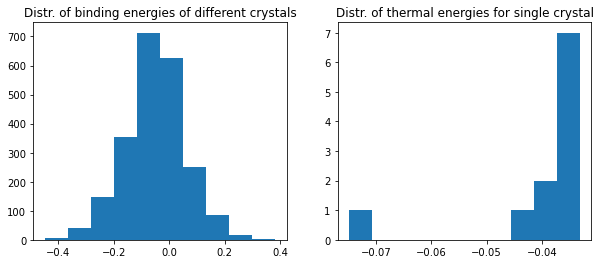

In [71]:
# Check variance in per-atom binding energies across crystals vs across thermally-perturbed configurations of the same crystal
X_tmp = np.zeros((len(db_fps[0::11]),4),dtype=int)
y_tmp=np.zeros(len(db_fps[0::11]))
for ifrm, frm in enumerate(db_fps[0::11]):
    symbols=frm.get_atomic_numbers()
    y_tmp[ifrm]=(frm.info['energy'])
    X_tmp[ifrm]=[len(np.where(symbols == sp)[0]) for sp in [1,6,7,8]]
    
f,p = plt.subplots(1,2,figsize=(10,4))
p[0].hist((y_tmp - mlr.predict(X_tmp))/np.sum(X_tmp,axis=1))
p[0].set_title('Distr. of binding energies of different crystals')

X_tmp = np.zeros((len(db_fps[:11]),4),dtype=int)
y_tmp=np.zeros(len(db_fps[:11]))
for ifrm, frm in enumerate(db_fps[:11]):
    symbols=frm.get_atomic_numbers()
    y_tmp[ifrm]=(frm.info['energy'])
    X_tmp[ifrm]=[len(np.where(symbols == sp)[0]) for sp in [1,6,7,8]]
    
p[1].hist((y_tmp - mlr.predict(X_tmp))/np.sum(X_tmp,axis=1))
p[1].set_title('Distr. of thermal energies for single crystal')


The plot below shows the model's ability to predict the relative energies of different configurations within the same crystal. Four model systems have been chosen for this test. As can be seen, the model is mostly unable (or poorly able) to rank the configurations' energies in the correct order.

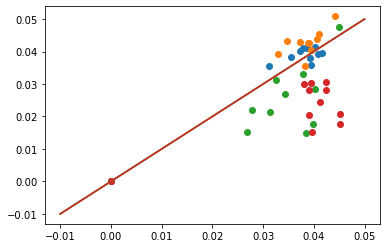

In [73]:
#Predict and plot relative energies of thermalised and geop configurations for the same crystal (calculated for 4 crystal systems)
KRR = KernelRidge(kernel='precomputed',alpha = 1e-6)
KRR.fit(K,yred_train)
err = np.std(yred_val - KRR.predict(Kval))

for i in range(4):
    tmp_feat=get_features(db_fps[i*11:(i+1)*11]) #get features for validation set
    Ktmp = np.dot(tmp_feat,train_feat.T)**zeta #compute covariance kernel matrix for validation

    X_tmp = np.zeros((len(db_fps[i*11:(i+1)*11]),4),dtype=int)
    y_tmp=np.zeros(len(db_fps[i*11:(i+1)*11]))
    for ifrm, frm in enumerate(db_fps[i*11:(i+1)*11]):
        symbols=frm.get_atomic_numbers()
        y_tmp[ifrm]=(frm.info['energy'])
        X_tmp[ifrm]=[len(np.where(symbols == sp)[0]) for sp in [1,6,7,8]]
    yref_tmp = (y_tmp - mlr.predict(X_tmp))/np.sum(X_tmp,axis=1)

    ypred_tmp = KRR.predict(Ktmp)
    plt.plot([-0.01,0.05],[-0.01,0.05])
    plt.scatter(yref_tmp-yref_tmp[0],ypred_tmp-ypred_tmp[0])